In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import math
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from lib.ci_draw import *

In [2]:
path = 'work/'
result_sic = np.load(path + 'result_sic.npy', allow_pickle=True).item()
result_dic = np.load(path + 'result_dic.npy', allow_pickle=True).item()
mimic_dic = np.load(path + 'mimic_dic.npy', allow_pickle=True).item()

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-(x)))

for key, value in mimic_dic.items():
    if value[1].max() > 1:
        print(key, value[1].max())
        mimic_dic[key] = (value[0], sigmoid(value[1]))

for key, value in result_sic.items():
    if value[1].max() > 1:
        print(key, value[1].max())
        result_sic[key] = (value[0], sigmoid(value[1]))

for key, value in result_dic.items():
    if value[1].max() > 1:
        print(key, value[1].max())
        result_dic[key] = (value[0], sigmoid(value[1]))

Xgboost 2.7078815
RNN-Decay 9.938108
ODE-RNN 16.079506


In [4]:
def roc_plot(result, size = (5,5), path = 'plot/roc_dic.svg'):
    plt.figure(figsize=size)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    for key, value in result.items():
        fpr, tpr, thresholds = roc_curve(value[0], value[1])
        roc_auc = roc_auc_score(value[0], value[1])
        plt.plot(fpr, tpr, label = key + ' (area = %0.4f)' % roc_auc )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(path)

def pr_plot(result, size = (5,5), path = 'plot/pr_dic.svg'):
    plt.figure(figsize=size)
    plt.plot([0, 1], [1, 0], color='navy', linestyle='--')
    for key, value in result.items():
        precision, recall, thresholds = precision_recall_curve(value[0], value[1])
        roc_auc = average_precision_score(value[0], value[1])
        plt.plot(recall, precision, label = key + ' (area = %0.4f)' % roc_auc )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.savefig(path)

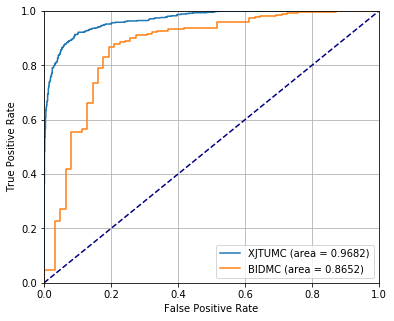

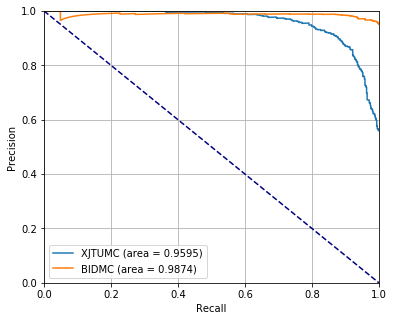

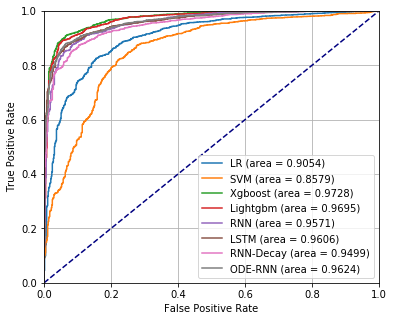

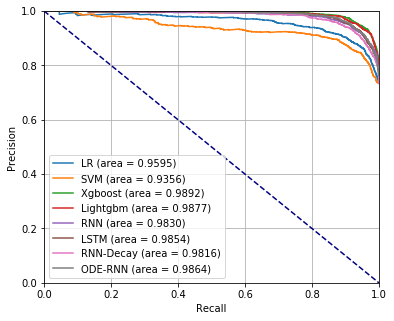

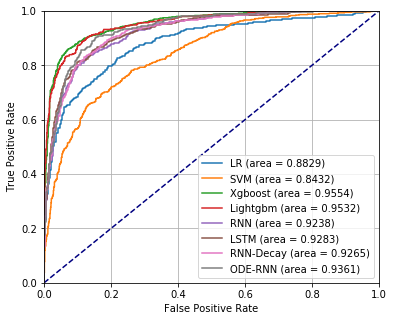

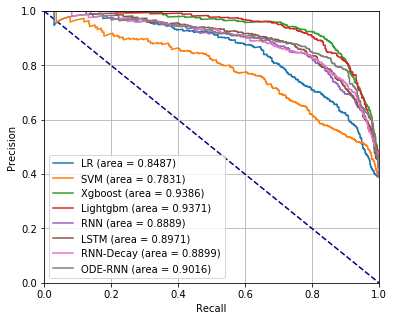

In [5]:
roc_plot(mimic_dic, size=(6,5), path = 'plot/roc_mimic.svg')
pr_plot(mimic_dic, size=(6,5), path = 'plot/pr_mimic.svg')
roc_plot(result_sic, size=(6,5), path = 'plot/roc_sic.svg')
pr_plot(result_sic, size=(6,5), path = 'plot/pr_sic.svg')
roc_plot(result_dic, size=(6,5), path = 'plot/roc_dic.svg')
pr_plot(result_dic, size=(6,5), path = 'plot/pr_dic.svg')

# Different thresholds

In [6]:
def get_prob_label(data, threshold):
    data_new = np.zeros(len(data))
    for ind, value in enumerate(data):
        if value >= threshold:
            data_new[ind]=1
    return data_new

def score_compute(value, thresholds, name):
    y_real = value[0]
    y_pred = get_prob_label(value[1], thresholds)
    [[tn,fp],[fn,tp]] = sklearn.metrics.confusion_matrix(y_real, y_pred)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    postive_value = tp/(tp+fp)
    negative_value = tn/(fn+tn)
    f1_score = 2*tp / (2*tp+fp+fn)
    return [name, thresholds, sensitivity, specificity, postive_value, negative_value, f1_score]

In [7]:
score_result = []
bound = [0.5,0.7,0.9]
for key, value in mimic_dic.items():
    for bou in bound:
        score_result.append(score_compute(value, bou, key))
score_result = np.array(score_result)
score_pd = pd.DataFrame(score_result, columns = ['模型', '阈值', '敏感度', '特异度', '阳性预测值', '阴性预测值', 'F1分数'])
score_pd.to_csv('output/mimic_dic.csv', encoding = 'gbk', index = None)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [8]:
score_result = []
bound = [0.5,0.7,0.9]
for key, value in result_sic.items():
    for bou in bound:
        score_result.append(score_compute(value, bou, key))
score_result = np.array(score_result)
score_pd = pd.DataFrame(score_result, columns = ['模型', '阈值', '敏感度', '特异度', '阳性预测值', '阴性预测值', 'F1分数'])
score_pd.to_csv('output/model_score_sic.csv', encoding = 'gbk', index = None)

In [9]:
score_result = []
bound = [0.5,0.7,0.9]
for key, value in result_dic.items():
    for bou in bound:
        score_result.append(score_compute(value, bou, key))
score_result = np.array(score_result)
score_pd = pd.DataFrame(score_result, columns = ['模型', '阈值', '敏感度', '特异度', '阳性预测值', '阴性预测值', 'F1分数'])
score_pd.to_csv('output/model_score_dic.csv', encoding = 'gbk', index=None)

# Plotting for article

In [ ]:
def roc_plot_mimic(result, size = (5,5), path = 'plot/roc_dic.svg'):
    mpl.rcParams['axes.linewidth'] = 0.5
    color = ['chartreuse', 'royalblue']
    label = ['XJTUMC', 'BIDMC']
    plt.figure(figsize=size)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=0.7)
    for ii, (key, value) in enumerate(result.items()):
        ci = get_95_ci(value[0], value[1], method='auc')[0]
        fpr, tpr, thresholds = roc_curve(value[0], value[1])
        roc_auc = roc_auc_score(value[0], value[1])
        plt.plot(fpr, tpr, label = label[ii] + ' %0.3f [%0.3f, %0.3f]' % (roc_auc,ci[0],ci[1]), 
                 linewidth=0.7, color = color[ii])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(linewidth=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right',frameon=False)
    plt.savefig(path)

def pr_plot_mimic(result, size = (5,5), path = 'plot/pr_dic.svg'):
    mpl.rcParams['axes.linewidth'] = 0.5
    color = ['chartreuse', 'royalblue']
    label = ['XJTUMC', 'BIDMC']
    plt.figure(figsize=size)
    y_min = 0
    for ii, (key, value) in enumerate(result.items()):
        ci = get_95_ci(value[0], value[1], method='ap')[0]
        precision, recall, thresholds = precision_recall_curve(value[0], value[1])
        roc_auc = average_precision_score(value[0], value[1])
        plt.plot(recall, precision, label = label[ii] + ' %0.3f [%0.3f, %0.3f]' % (roc_auc,ci[0],ci[1]), 
                 linewidth=0.7, color = color[ii])
        if y_min > min(precision):
            y_min = min(precision)
    plt.xlim([0, 1])
    plt.ylim([y_min, 1])
    plt.grid(linewidth=0.4)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left', frameon=False)
    plt.savefig(path)

In [ ]:
def roc_plot(result, size = (5,5), path = 'plot/roc_dic.svg'):
    mpl.rcParams['axes.linewidth'] = 0.5
    color = ['chartreuse', 'darkorange', 'plum', 'cyan',
             'orangered', 'royalblue', 'yellow', 'magenta']
    label = ['LR', 'SVM', 'XGBoost', 'LightGBM', 'RNN', 'LSTM', 'RNN-Decay', 'ODE-RNN']
    plt.figure(figsize=size)
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=0.7)
    for ii, (key, value) in enumerate(result.items()):
        ci = get_95_ci(value[0], value[1], method='auc')[0]
        fpr, tpr, thresholds = roc_curve(value[0], value[1])
        roc_auc = roc_auc_score(value[0], value[1])
        plt.plot(fpr, tpr, label = label[ii] + ' %0.3f [%0.3f, %0.3f]' % (roc_auc,ci[0],ci[1]), 
                 linewidth=0.7, color = color[ii])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(linewidth=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right',frameon=False)
    plt.savefig(path)

def pr_plot(result, size = (5,5), path = 'plot/pr_dic.svg'):
    mpl.rcParams['axes.linewidth'] = 0.5
    color = ['chartreuse', 'darkorange', 'plum', 'cyan',
             'orangered', 'royalblue', 'yellow', 'magenta']
    label = ['LR', 'SVM', 'XGBoost', 'LightGBM', 'RNN', 'LSTM', 'RNN-Decay', 'ODE-RNN']
    plt.figure(figsize=size)
    y_min = 0
    for ii, (key, value) in enumerate(result.items()):
        ci = get_95_ci(value[0], value[1], method='ap')[0]
        precision, recall, thresholds = precision_recall_curve(value[0], value[1])
        roc_auc = average_precision_score(value[0], value[1])
        plt.plot(recall, precision, label = label[ii] + ' %0.3f [%0.3f, %0.3f]' % (roc_auc,ci[0],ci[1]), 
                 linewidth=0.7, color = color[ii])
        if y_min > min(precision):
            y_min = min(precision)
    plt.xlim([0, 1])
    plt.ylim([y_min, 1])
    plt.grid(linewidth=0.4)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left', frameon=False)
    plt.savefig(path)

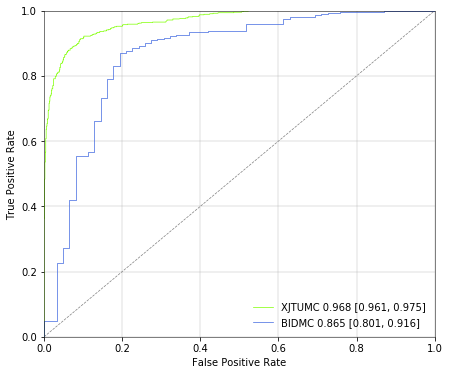

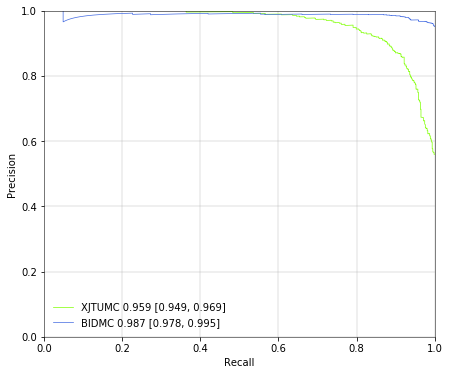

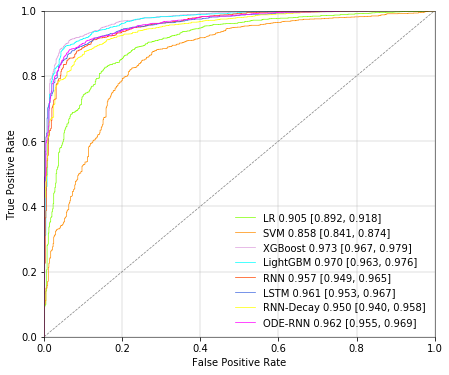

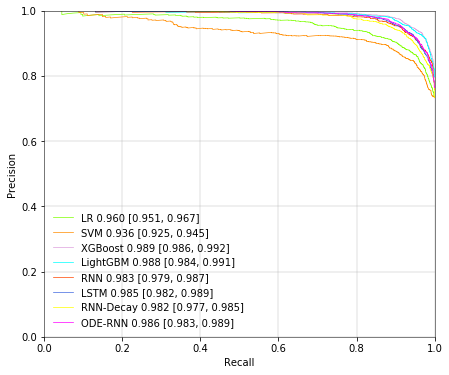

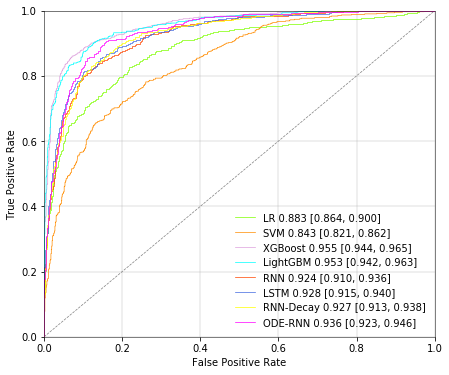

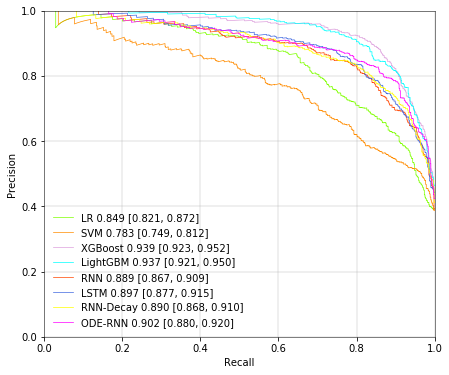

In [ ]:
roc_plot_mimic(mimic_dic, size=(7,6), path = 'plot/roc_mimic.svg')
pr_plot_mimic(mimic_dic, size=(7,6), path = 'plot/pr_mimic.svg')
roc_plot(result_sic, size=(7,6), path = 'plot/roc_sic.svg')
pr_plot(result_sic, size=(7,6), path = 'plot/pr_sic.svg')
roc_plot(result_dic, size=(7,6), path = 'plot/roc_dic.svg')
pr_plot(result_dic, size=(7,6), path = 'plot/pr_dic.svg')

# Plotting result

In [ ]:
result = pd.read_csv('result.csv').values
color = ['chartreuse', 'darkorange', 'plum', 'cyan', 'orangered', 'royalblue', 'yellow', 'magenta']

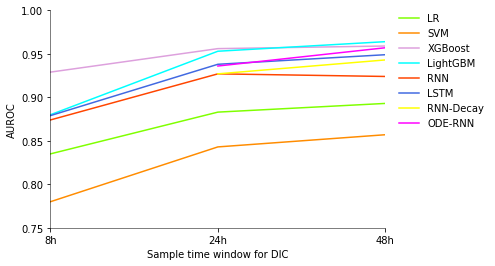

In [ ]:
plt.figure(figsize=(6,4))
for i in range(8):
    plt.plot(result[1+i,7:].T.astype(np.float32), color = color[i])
# plt.grid()
plt.xticks([0,1,2], ['8h','24h', '48h'])
plt.xlabel('Sample time window for DIC')
plt.ylabel('AUROC')
plt.axis([0, 2, 0.75, 1])
plt.legend(result[1:9,0], loc=[1.03,0.44], frameon=False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.savefig('plot/windows_sample_dic.svg', bbox_inches = 'tight')

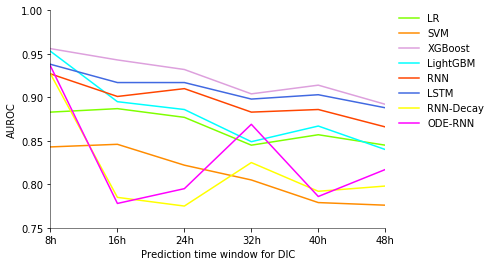

In [ ]:
fig = plt.figure(figsize=(6,4))
for i in range(8):
    plt.plot(result[1+i,1:7].T.astype(np.float32), color = color[i])
# plt.grid()
plt.xticks([0,1,2,3,4,5], ['8h', '16h', '24h', '32h', '40h', '48h'])
plt.xlabel('Prediction time window for DIC')
plt.ylabel('AUROC')
plt.axis([0, 5, 0.75, 1])
plt.legend(result[1:9,0], loc=[1.03,0.44], frameon=False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.savefig('plot/windows_pred_dic.svg', bbox_inches = 'tight')

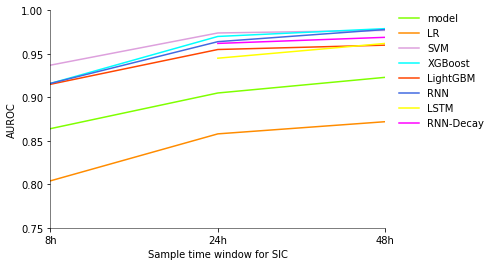

In [ ]:
plt.figure(figsize=(6,4))
for i in range(8):
    plt.plot(result[11+i,7:].T.astype(np.float32), color = color[i])
# plt.grid()
plt.xticks([0,1,2], ['8h','24h', '48h'])
plt.xlabel('Sample time window for SIC')
plt.ylabel('AUROC')
plt.axis([0, 2, 0.75, 1])
plt.legend(result[10:19,0], loc=[1.03,0.44], frameon=False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.savefig('plot/windows_sample_sic.svg', bbox_inches = 'tight')

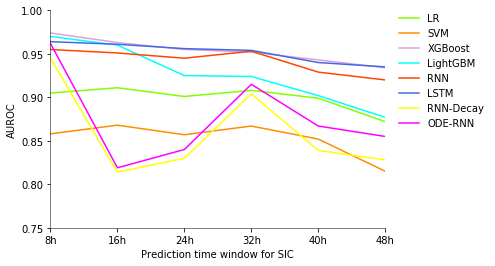

In [ ]:
plt.figure(figsize=(6,4))
for i in range(8):
    plt.plot(result[11+i,1:7].T.astype(np.float32), color = color[i])
# plt.grid()
plt.xticks([0,1,2,3,4,5], ['8h', '16h', '24h', '32h', '40h', '48h'])
plt.xlabel('Prediction time window for SIC')
plt.ylabel('AUROC')
plt.axis([0, 5, 0.75, 1])
plt.legend(result[1:9,0], loc=[1.03,0.44], frameon=False)
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.savefig('plot/windows_pred_sic.svg', bbox_inches = 'tight')